In [1]:
import sys
import os
import warnings

sys.path.append(os.path.abspath("modules/"))
sys.path.append(os.path.abspath("fe_modules/"))
sys.path.append(os.path.abspath("seq2seq_modules/"))

os.environ['OPENBLAS_NUM_THREADS'] = '1'
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import time
import pyarrow.parquet as pq
import polars as pl
import scipy
import implicit
import bisect
import sklearn.metrics as m
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

In [3]:
import importlib

import modules
import fe_modules

importlib.reload(modules)
importlib.reload(fe_modules)

from modules.memory_utils import polars_reduce_mem_usage

In [4]:
LOCAL_DATA_PATH = './context_data/'
SPLIT_SEED = 42
DATA_FILE = 'competition_data_final_pqt/'
TARGET_FILE = 'competition_target_pqt/'

In [5]:
df = polars_reduce_mem_usage(
    pl.read_parquet(
        f'context_data/competition_data_final_pqt/part-00000-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet'
    ))
df

Memory usage of dataframe is 6059.32 MB
Memory usage of dataframe is 5.92 GB
utf
utf
utf
utf
utf
utf
utf
flo
dat
utf
int
int
Memory usage after optimization is: 5592.42 MB
Memory usage  after optimization is 5.46 GB
Decreased by 7.7%


region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id
str,str,str,str,str,str,str,f32,date,str,i8,i32
"""Краснодарский ...","""Краснодар""","""Apple""","""iPhone 7""","""ad.adriver.ru""","""smartphone""","""iOS""",20368.0,2022-06-15,"""morning""",1,45098
"""Краснодарский ...","""Краснодар""","""Apple""","""iPhone 7""","""apple.com""","""smartphone""","""iOS""",20368.0,2022-06-19,"""morning""",1,45098
"""Краснодарский ...","""Краснодар""","""Apple""","""iPhone 7""","""avatars.mds.ya...","""smartphone""","""iOS""",20368.0,2022-06-12,"""day""",1,45098
"""Краснодарский ...","""Краснодар""","""Apple""","""iPhone 7""","""googleads.g.do...","""smartphone""","""iOS""",20368.0,2022-05-16,"""day""",1,45098
"""Краснодарский ...","""Краснодар""","""Apple""","""iPhone 7""","""googleads.g.do...","""smartphone""","""iOS""",20368.0,2022-05-30,"""day""",1,45098
"""Краснодарский ...","""Краснодар""","""Apple""","""iPhone 7""","""i.ytimg.com""","""smartphone""","""iOS""",20368.0,2022-03-29,"""evening""",2,45098
"""Краснодарский ...","""Краснодар""","""Apple""","""iPhone 7""","""icloud.com""","""smartphone""","""iOS""",20368.0,2022-03-17,"""morning""",1,45098
"""Краснодарский ...","""Краснодар""","""Apple""","""iPhone 7""","""m.avito.ru""","""smartphone""","""iOS""",20368.0,2022-05-19,"""morning""",1,45098
"""Краснодарский ...","""Краснодар""","""Apple""","""iPhone 7""","""relap.io""","""smartphone""","""iOS""",20368.0,2022-03-29,"""night""",1,45098


# Feature engeneering

In [6]:
from fe_modules.aggregates import get_agg_count, \
                                  get_agg_sum, \
                                  get_agg_mode, \
                                  get_agg_mean, \
                                  get_price_of_all_cpes, \
                                  get_agg_n_unique

from fe_modules.datetime import get_timestamp

In [8]:
df = get_timestamp(df, "date")
df

region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id,timestamp
str,str,str,str,str,str,str,f32,date,str,i8,i32,i64
"""Краснодарский ...","""Краснодар""","""Apple""","""iPhone 7""","""ad.adriver.ru""","""smartphone""","""iOS""",20368.0,2022-06-15,"""morning""",1,45098,1655251200000000
"""Краснодарский ...","""Краснодар""","""Apple""","""iPhone 7""","""apple.com""","""smartphone""","""iOS""",20368.0,2022-06-19,"""morning""",1,45098,1655596800000000
"""Краснодарский ...","""Краснодар""","""Apple""","""iPhone 7""","""avatars.mds.ya...","""smartphone""","""iOS""",20368.0,2022-06-12,"""day""",1,45098,1654992000000000
"""Краснодарский ...","""Краснодар""","""Apple""","""iPhone 7""","""googleads.g.do...","""smartphone""","""iOS""",20368.0,2022-05-16,"""day""",1,45098,1652659200000000
"""Краснодарский ...","""Краснодар""","""Apple""","""iPhone 7""","""googleads.g.do...","""smartphone""","""iOS""",20368.0,2022-05-30,"""day""",1,45098,1653868800000000
"""Краснодарский ...","""Краснодар""","""Apple""","""iPhone 7""","""i.ytimg.com""","""smartphone""","""iOS""",20368.0,2022-03-29,"""evening""",2,45098,1648512000000000
"""Краснодарский ...","""Краснодар""","""Apple""","""iPhone 7""","""icloud.com""","""smartphone""","""iOS""",20368.0,2022-03-17,"""morning""",1,45098,1647475200000000
"""Краснодарский ...","""Краснодар""","""Apple""","""iPhone 7""","""m.avito.ru""","""smartphone""","""iOS""",20368.0,2022-05-19,"""morning""",1,45098,1652918400000000
"""Краснодарский ...","""Краснодар""","""Apple""","""iPhone 7""","""relap.io""","""smartphone""","""iOS""",20368.0,2022-03-29,"""night""",1,45098,1648512000000000


In [ ]:
q = df.sort("timestamp").groupby("cpe_model_name").agg([pl.col("timestamp"), pl.col("price")])
q

In [10]:
df = get_agg_n_unique(df, target_col="price", alias="num_cpe")
df

region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id,timestamp,num_cpe
str,str,str,str,str,str,str,f32,date,str,i8,i32,i64,u32
"""Краснодарский ...","""Анапа""","""Huawei""","""Nova 3""","""kp.md""","""smartphone""","""Android""",12990.0,2021-07-23,"""morning""",1,4,1626998400000000,1
"""Краснодарский ...","""Анапа""","""Huawei""","""Nova 3""","""yastatic.net""","""smartphone""","""Android""",12990.0,2021-07-23,"""evening""",1,4,1626998400000000,1
"""Краснодарский ...","""Новороссийск""","""Huawei""","""Nova 3""","""avatars.mds.ya...","""smartphone""","""Android""",12990.0,2021-07-21,"""day""",1,4,1626825600000000,1
"""Краснодарский ...","""Анапа""","""Huawei""","""Nova 3""","""sun9-85.userap...","""smartphone""","""Android""",12990.0,2021-07-24,"""evening""",1,4,1627084800000000,1
"""Краснодарский ...","""Анапа""","""Huawei""","""Nova 3""","""yhb.p.otm-r.co...","""smartphone""","""Android""",12990.0,2021-07-24,"""morning""",1,4,1627084800000000,1
"""Краснодарский ...","""Анапа""","""Huawei""","""Nova 3""","""ads.betweendig...","""smartphone""","""Android""",12990.0,2021-07-18,"""day""",1,4,1626566400000000,1
"""Республика Баш...","""Нефтекамск""","""Huawei""","""Nova 3""","""ads.adfox.ru""","""smartphone""","""Android""",12990.0,2021-06-23,"""day""",1,4,1624406400000000,1
"""Краснодарский ...","""Анапа""","""Huawei""","""Nova 3""","""i.ytimg.com""","""smartphone""","""Android""",12990.0,2021-07-23,"""evening""",3,4,1626998400000000,1
"""Краснодарский ...","""Анапа""","""Huawei""","""Nova 3""","""s0.2mdn.net""","""smartphone""","""Android""",12990.0,2021-07-18,"""morning""",1,4,1626566400000000,1


In [13]:
q = df.filter(pl.col("num_cpe") > 1)
q

region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id,timestamp,num_cpe
str,str,str,str,str,str,str,f32,date,str,i8,i32,i64,u32
"""Москва""","""Москва""","""Apple""","""iPhone X""","""node1.online.s...","""smartphone""","""iOS""",30990.0,2021-07-25,"""morning""",1,303,1627171200000000,2
"""Москва""","""Москва""","""Apple""","""iPhone X""","""discord.com""","""smartphone""","""iOS""",39990.0,2021-06-30,"""night""",1,303,1625011200000000,2
"""Москва""","""Москва""","""Apple""","""iPhone X""","""googleads.g.do...","""smartphone""","""iOS""",39990.0,2021-07-04,"""evening""",1,303,1625356800000000,2
"""Москва""","""Москва""","""Apple""","""iPhone X""","""instagram.com""","""smartphone""","""iOS""",39990.0,2021-07-03,"""day""",1,303,1625270400000000,2
"""Москва""","""Москва""","""Apple""","""iPhone X""","""google.com""","""smartphone""","""iOS""",39990.0,2021-06-27,"""day""",1,303,1624752000000000,2
"""Москва""","""Москва""","""Apple""","""iPhone X""","""online.sberban...","""smartphone""","""iOS""",39990.0,2021-07-21,"""day""",1,303,1626825600000000,2
"""Московская обл...","""Реутов""","""Apple""","""iPhone X""","""ad.mail.ru""","""smartphone""","""iOS""",30990.0,2021-07-24,"""day""",1,303,1627084800000000,2
"""Москва""","""Москва""","""Apple""","""iPhone X""","""i.ytimg.com""","""smartphone""","""iOS""",39990.0,2021-07-16,"""day""",1,303,1626393600000000,2
"""Москва""","""Москва""","""Apple""","""iPhone X""","""vk.com""","""smartphone""","""iOS""",39990.0,2021-07-14,"""evening""",2,303,1626220800000000,2


In [30]:
q2 = q.sort("timestamp").groupby("user_id").agg([pl.col("timestamp"), pl.col("price"), pl.col("cpe_model_name").unique()])
q2

user_id,timestamp,price,cpe_model_name
i32,list[i64],list[f32],list[str]
350064,"[1623801600000000, 1623801600000000, ... 1629158400000000]","[14990.0, 14990.0, ... 17490.0]","[""Galaxy M21""]"
350696,"[1627948800000000, 1629158400000000, ... 1629244800000000]","[12993.0, 9490.0, ... 9490.0]","[""Galaxy A20 Dual""]"
104728,"[1649721600000000, 1649721600000000, ... 1655337600000000]","[163626.0, 163626.0, ... 137768.0]","[""iPhone 13 Pro""]"
340800,"[1623801600000000, 1623801600000000, ... 1624838400000000]","[20712.0, 20712.0, ... 11133.0]","[""Galaxy A50 Dual""]"
142984,"[1624579200000000, 1624579200000000, ... 1627516800000000]","[40804.0, 40804.0, ... 37541.0]","[""iPhone SE 2020""]"
68888,"[1623801600000000, 1623801600000000, ... 1626048000000000]","[4915.0, 4915.0, ... 3490.0]","[""Honor 7C""]"
104800,"[1623801600000000, 1623801600000000, ... 1628899200000000]","[7302.0, 7302.0, ... 5990.0]","[""Redmi 7A""]"
290640,"[1625270400000000, 1628380800000000, ... 1630108800000000]","[21996.0, 21996.0, ... 15990.0]","[""iPhone 6""]"
60904,"[1623801600000000, 1623801600000000, ... 1625702400000000]","[8101.0, 8101.0, ... 6240.0]","[""iPhone SE""]"


In [31]:
user_sample = q2.filter(pl.col("user_id") == 413913)
user_sample

user_id,timestamp,price,cpe_model_name
i32,list[i64],list[f32],list[str]
413913,"[1624320000000000, 1624320000000000, ... 1629936000000000]","[13140.0, 13140.0, ... 15516.0]","[""Galaxy A31""]"


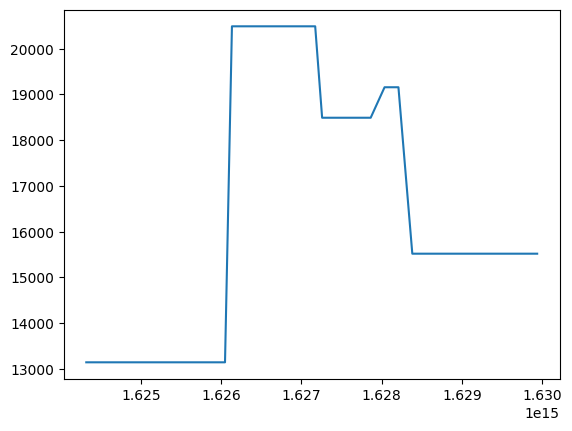

In [32]:
import matplotlib.pyplot as plt

plt.plot(user_sample["timestamp"][0], user_sample["price"][0])

In [ ]:
import seaborn as sns

sns.distplot(df["price"])